# 1. Initial Setup and Data Loading

In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load the dataset
df = pd.read_csv("Insurance_Claims().csv")



# 2. Initial Data Cleaning

In [ ]:
# Drop unnecessary columns
df.drop(columns=['_c39'], inplace=True)

# Handle missing values in 'authorities_contacted' (91 missing)
print("Missing values before treatment:")
print(df.isnull().sum()[df.isnull().sum() > 0])



Missing values before treatment:
authorities_contacted    91
dtype: int64


# 3. Data Type Conversion

In [ ]:
df.isnull().sum()

,0
months_as_customer,0
age,0
policy_number,0
policy_bind_date,0
policy_state,0
policy_csl,0
policy_deductable,0
policy_annual_premium,0
umbrella_limit,0
insured_zip,0


In [ ]:
# ====== A. Numeric Columns (Excluding Target & Components) ======
numeric_cols = [
    'months_as_customer', 'age', 'policy_deductable',
    'policy_annual_premium', 'umbrella_limit', 'capital-gains',
    'capital-loss', 'incident_hour_of_the_day',
    'number_of_vehicles_involved', 'bodily_injuries',
    'witnesses', 'auto_year'  # Removed: injury_claim, property_claim, vehicle_claim
]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# ====== B. Datetime Columns ======
df['policy_bind_date'] = pd.to_datetime(df['policy_bind_date'], errors='coerce')
df['incident_date'] = pd.to_datetime(df['incident_date'], errors='coerce')

# ====== C. Categorical Columns ======
categorical_cols = [
    'policy_state', 'policy_csl', 'insured_zip', 'insured_sex',
    'insured_education_level', 'insured_occupation', 'insured_hobbies',
    'insured_relationship', 'incident_type', 'collision_type',
    'incident_severity', 'authorities_contacted', 'incident_state',
    'incident_city', 'incident_location', 'auto_make', 'auto_model'
]
df[categorical_cols] = df[categorical_cols].astype('category')

# ====== D. Binary Columns ======
binary_cols = ['property_damage', 'police_report_available', 'fraud_reported']
# Step 1: Replace values with 1/0/NaN
df[binary_cols] = df[binary_cols].replace({'YES': 1, 'NO': 0, 'Y': 1, 'N': 0, '?': np.nan})


<ipython-input-5-2fe69ae92d08>:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[binary_cols] = df[binary_cols].replace({'YES': 1, 'NO': 0, 'Y': 1, 'N': 0, '?': np.nan})


# 4. Missing Value Treatment

In [ ]:
# ====== Imputation ======
from sklearn.impute import SimpleImputer

# --- 1. Numeric Columns: Median Imputation ---
num_imputer = SimpleImputer(strategy='median')
df[numeric_cols] = num_imputer.fit_transform(df[numeric_cols])

# --- 2. Categorical Columns: Mode Imputation ---
cat_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])
df[categorical_cols] = df[categorical_cols].astype('category')

# --- 3. Binary Columns: Mode Imputation ---
binary_imputer = SimpleImputer(strategy='most_frequent')
df[binary_cols] = binary_imputer.fit_transform(df[binary_cols])  # Fix missing values
df[binary_cols] = df[binary_cols].astype('int')  # Convert to int AFTER imputation



# 5. Feature Engineering

In [ ]:
# ====== Feature Engineering (No Target Leakage!) ======
# --- Policy Duration (Fix negative values) ---
df['policy_duration'] = (df['incident_date'] - df['policy_bind_date']).dt.days
df['policy_duration'] = df['policy_duration'].mask(df['policy_duration'] < 0, np.nan)
df['policy_duration'] = num_imputer.fit_transform(df[['policy_duration']])  # Re-impute

# --- Cyclical Encoding for Time Features ---
df['incident_month_sin'] = np.sin(2 * np.pi * df['incident_date'].dt.month / 12)
df['incident_month_cos'] = np.cos(2 * np.pi * df['incident_date'].dt.month / 12)
df['incident_dayofweek_sin'] = np.sin(2 * np.pi * df['incident_date'].dt.dayofweek / 7)
df['incident_dayofweek_cos'] = np.cos(2 * np.pi * df['incident_date'].dt.dayofweek / 7)

# --- Non-Leaky Features ---
df['claim_frequency'] = df['number_of_vehicles_involved'] / (df['policy_duration'] + 1e-6)

In [ ]:
print("Missing Values After Imputation:")
print(df[['police_report_available', 'property_damage', 'authorities_contacted']].isnull().sum())

Missing Values After Imputation:
police_report_available    0
property_damage            0
authorities_contacted      0
dtype: int64


In [ ]:
# Define the education_order and severity_order dictionaries before they are used
education_order = {'High School': 0, 'College': 1, 'Associate': 2,
                  'Masters': 3, 'PhD': 4, 'MD': 5, 'JD': 6}
severity_order = {'Trivial Damage': 0, 'Minor Damage': 1,
                 'Major Damage': 2, 'Total Loss': 3}


# Check for unmapped categories
missing_edu = set(df['insured_education_level'].unique()) - set(education_order.keys())
missing_sev = set(df['incident_severity'].unique()) - set(severity_order.keys())
assert not missing_edu, f"Missing education levels: {missing_edu}"
assert not missing_sev, f"Missing severity levels: {missing_sev}"

In [ ]:
# Auto-detect rare categories
threshold = 0.01  # 1%
occupation_counts = df['insured_occupation'].value_counts(normalize=True)
rare_occupations = occupation_counts[occupation_counts < threshold].index
df['insured_occupation'] = df['insured_occupation'].replace(rare_occupations, 'Other')

#EDA BEFORE ENCODING

Unique values in insured_zip: 995


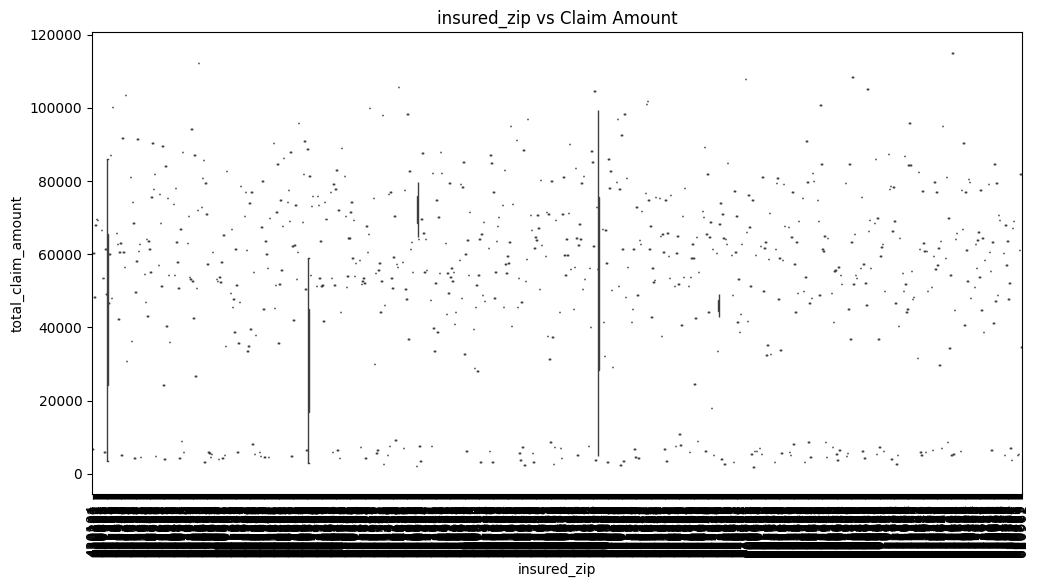

Unique values in incident_city: 7


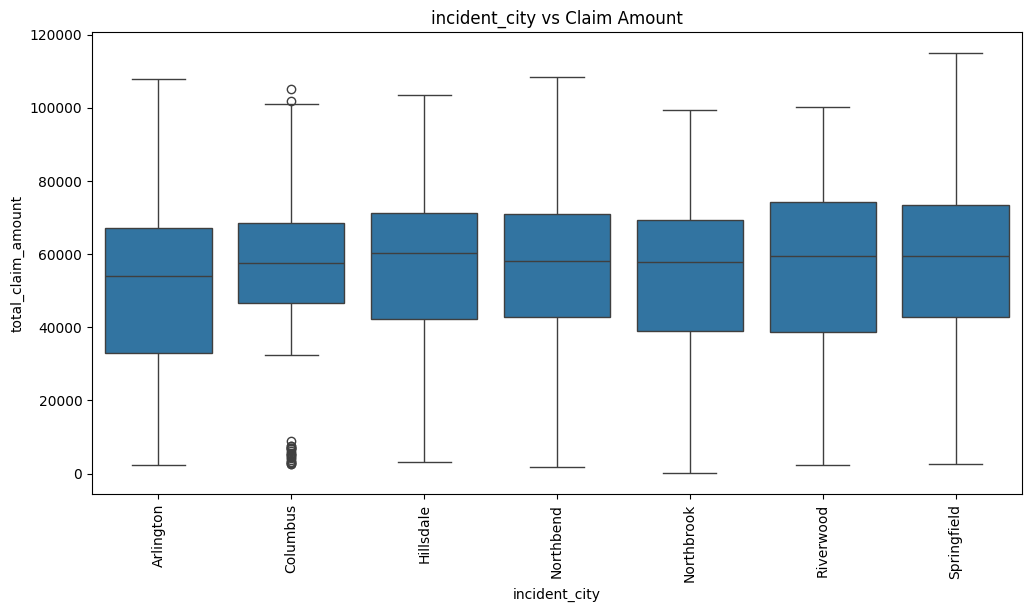

Unique values in incident_location: 1000


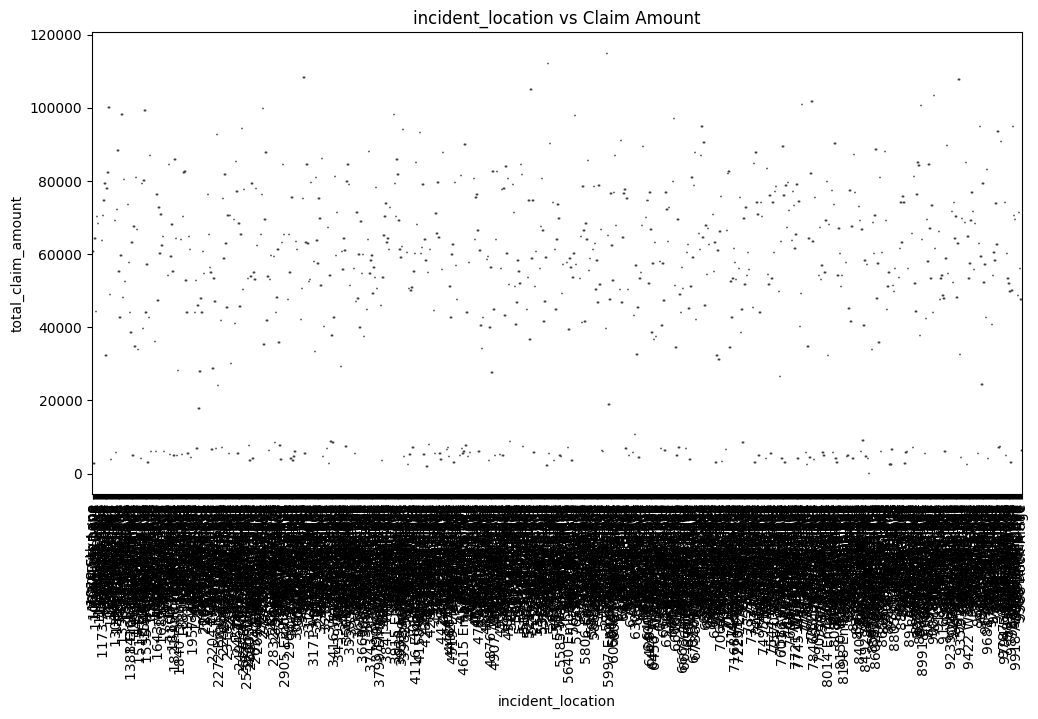

Unique values in auto_model: 39


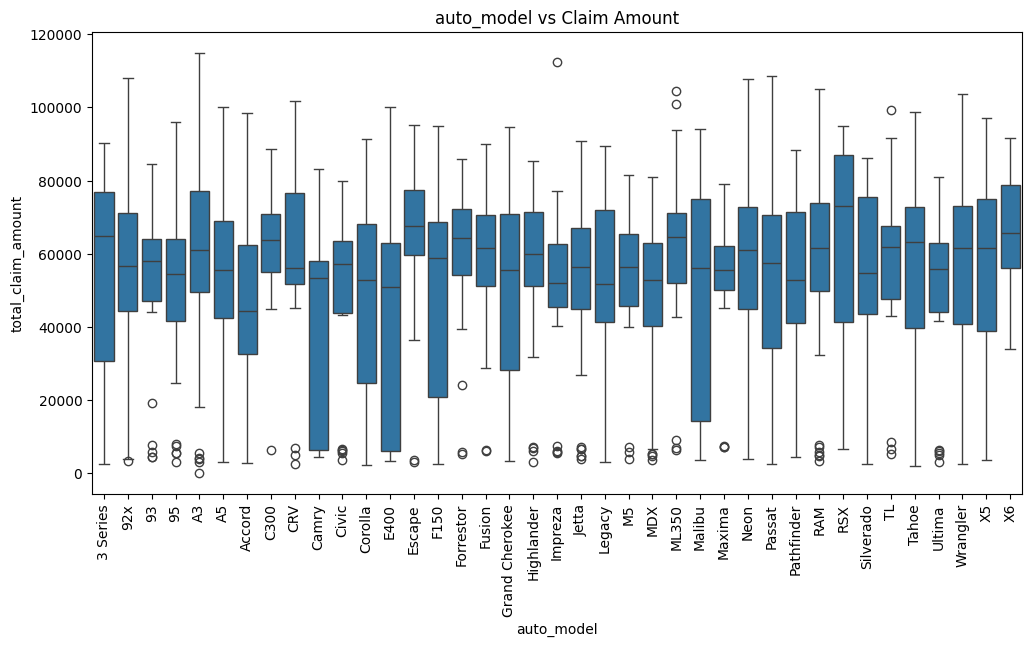

Education Levels: ['MD', 'PhD', 'Associate', 'Masters', 'High School', 'College', 'JD']
Categories (7, object): ['Associate', 'College', 'High School', 'JD', 'MD', 'Masters', 'PhD']
Incident Severity Levels: ['Major Damage', 'Minor Damage', 'Total Loss', 'Trivial Damage']
Categories (4, object): ['Major Damage', 'Minor Damage', 'Total Loss', 'Trivial Damage']


In [ ]:
# -------------------------------
# EDA 1: High-Cardinality Features
# -------------------------------
high_card_cols = ['insured_zip', 'incident_city', 'incident_location', 'auto_model']
for col in high_card_cols:
    print(f"Unique values in {col}: {df[col].nunique()}")
    # Plot relationship with target
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=col, y='total_claim_amount', data=df)
    plt.xticks(rotation=90)
    plt.title(f'{col} vs Claim Amount')
    plt.show()

# -------------------------------
# EDA 2: Ordinal Feature Validation
# -------------------------------
# Check if the manual order matches actual data
print("Education Levels:", df['insured_education_level'].unique())
print("Incident Severity Levels:", df['incident_severity'].unique())

In [ ]:
print(X.shape, X_trimmed.shape)


NameError: name 'X' is not defined

In [ ]:
print(df[['insured_zip_encoded', 'incident_city_encoded', 'incident_location_encoded', 'auto_model_encoded']].isna().sum())


KeyError: "None of [Index(['insured_zip_encoded', 'incident_city_encoded',\n       'incident_location_encoded', 'auto_model_encoded'],\n      dtype='object')] are in the [columns]"

In [ ]:
print(df.shape)  # Should be (1000, N) and not (830, N) if no trimming was done


(1000, 45)


In [ ]:
print(X_trimmed[X_trimmed['insured_zip_encoded'].isna()].head())  # Look at rows with NaNs


   months_as_customer   age  policy_deductable  policy_annual_premium  \
0               328.0  48.0             1000.0                1406.91   
2               134.0  29.0             2000.0                1413.14   
3               256.0  41.0             2000.0                1415.74   
5               256.0  39.0             1000.0                1351.10   
6               137.0  34.0             1000.0                1333.35   

   umbrella_limit  capital-gains  capital-loss  incident_severity  \
0             0.0        53300.0           0.0                  2   
2       5000000.0        35100.0           0.0                  1   
3       6000000.0        48900.0      -62400.0                  2   
5             0.0            0.0           0.0                  2   
6             0.0            0.0      -77000.0                  1   

   incident_hour_of_the_day  number_of_vehicles_involved  ...  \
0                       5.0                          1.0  ...   
2               

# 6. Strategic Encoding

In [ ]:
missing_cols = [col for col in high_card_cols if col not in df.columns]
if missing_cols:
    print(f"Columns missing in DataFrame: {missing_cols}")


In [ ]:
# Calculate global median of the target
global_median = df['total_claim_amount'].median()

# Mean encode with smoothing (prevents overfitting)
for col in high_card_cols:
    # Calculate median claim per category
    medians = df.groupby(col)['total_claim_amount'].median()
    # Calculate count per category
    counts = df.groupby(col)['total_claim_amount'].count()

    # Smoothing hyperparameter (adjust based on EDA)
    smoothing = 100

    # Smoothed median encoding
    smoothed_values = (medians * counts + global_median * smoothing) / (counts + smoothing)

    # Assign values to the dataset
    # Convert the new column to numeric dtype to avoid category errors
    df[col + '_encoded'] = df[col].map(smoothed_values).astype(float)

    # Fill NaNs with global median to prevent missing values
    df[col + '_encoded'].fillna(global_median, inplace=True)

# Drop original high-cardinality columns
df.drop(columns=high_card_cols, inplace=True)

<ipython-input-102-afa70f5773b4>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = df.groupby(col)['total_claim_amount'].median()
<ipython-input-102-afa70f5773b4>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby(col)['total_claim_amount'].count()
<ipython-input-102-afa70f5773b4>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

In [ ]:
print(df.isna().sum())

months_as_customer             0
age                            0
policy_number                  0
policy_bind_date               0
policy_state                   0
policy_csl                     0
policy_deductable              0
policy_annual_premium          0
umbrella_limit                 0
insured_sex                    0
insured_education_level        0
insured_occupation             0
insured_hobbies                0
insured_relationship           0
capital-gains                  0
capital-loss                   0
incident_date                  0
incident_type                  0
collision_type                 0
incident_severity              0
authorities_contacted          0
incident_state                 0
incident_hour_of_the_day       0
number_of_vehicles_involved    0
property_damage                0
bodily_injuries                0
witnesses                      0
police_report_available        0
total_claim_amount             0
injury_claim                   0
property_c

In [ ]:
df[['insured_zip_encoded', 'incident_city_encoded', 'incident_location_encoded', 'auto_model_encoded']].describe()


,insured_zip_encoded,incident_city_encoded,incident_location_encoded,auto_model_encoded
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,58001.735088,58073.339041,58002.593465,58046.333839
std,260.844625,1155.475590,261.401319,923.510233
min,57481.188119,55639.285714,57481.188119,56470.265487
25%,57891.732673,57836.586345,57894.183168,57432.868852
50%,58053.267327,58105.306122,58055.000000,57918.852459
75%,58178.514851,58876.653696,58179.133663,58863.868613
max,58618.019802,59380.165975,58618.019802,59877.258065


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
encoded_cols = ['insured_zip_encoded', 'incident_city_encoded', 'incident_location_encoded', 'auto_model_encoded']

df[encoded_cols] = scaler.fit_transform(df[encoded_cols])


# 7. Final Data Preparation


In [ ]:
# Drop original columns we no longer need (fixed typo in 'incident_date')
cols_to_drop = ['policy_bind_date', 'incident_date', 'insured_hobbies',
               'injury_claim', 'property_claim', 'vehicle_claim']
df = df.drop(columns=cols_to_drop, errors='ignore')

if 'total_claim_amount' in df.columns:
    df['log_claim_amount'] = np.log1p(df['total_claim_amount'])
    # Keep original for EDA comparison
    df['original_claim_amount'] = df['total_claim_amount']

# Verify final datatypes
print("\nFinal Data Types:")
print(df.dtypes.value_counts())  # More concise view

# Check for remaining missing values
missing_values = df.isnull().sum()
print("\nRemaining Missing Values:")
print(missing_values[missing_values > 0])


Final Data Types:
float64     23
int64        6
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
Name: count, dtype: int64

Remaining Missing Values:
insured_zip_encoded          1000
incident_city_encoded        1000
incident_location_encoded    1000
auto_model_encoded           1000
dtype: int64


##EDA

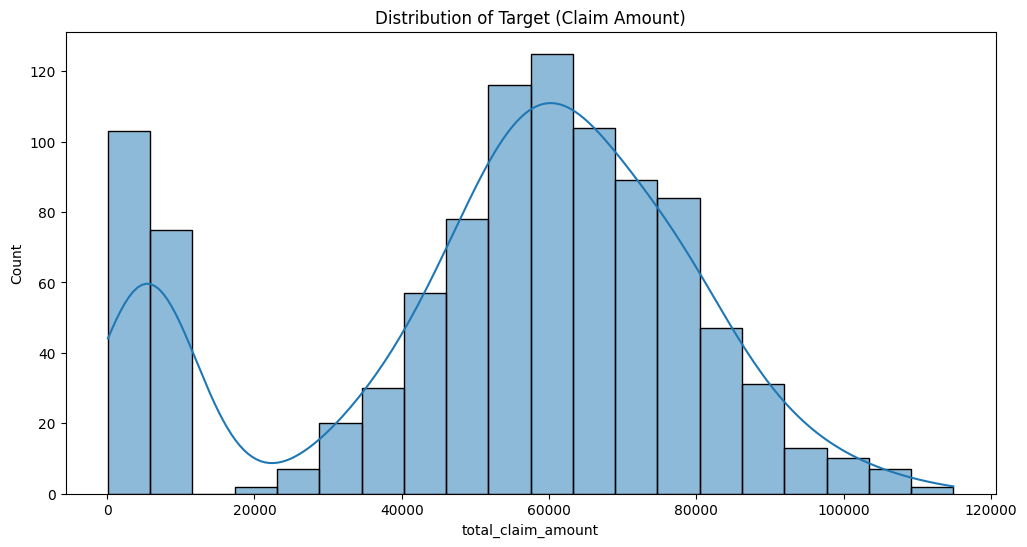

Skewness: -0.59 | Kurtosis: -0.45


In [ ]:
# -------------------------------
# 1.1 Target Variable Analysis
# -------------------------------
plt.figure(figsize=(12, 6))
sns.histplot(df['total_claim_amount'], kde=True)
plt.title('Distribution of Target (Claim Amount)')
plt.show()

# Check skewness/kurtosis
skew = df['total_claim_amount'].skew()
kurt = df['total_claim_amount'].kurtosis()
print(f"Skewness: {skew:.2f} | Kurtosis: {kurt:.2f}")






In [ ]:
# Keep claims ≥ $16,000
df_trimmed = df[df['total_claim_amount'] >= 16000].copy()
print(f"Original Size: {len(df)}, Trimmed Size: {len(df_trimmed)}")


Original Size: 1000, Trimmed Size: 822


Skewness (Trimmed): 0.20685509810814962


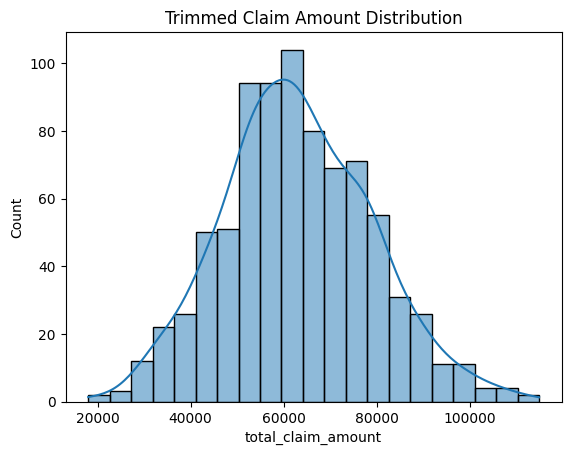

In [ ]:
print("Skewness (Trimmed):", df_trimmed['total_claim_amount'].skew())
sns.histplot(df_trimmed['total_claim_amount'], kde=True)
plt.title('Trimmed Claim Amount Distribution')
plt.show()

In [ ]:
print("Kurtosis (Trimmed):", df_trimmed['total_claim_amount'].kurt())


Kurtosis (Trimmed): -0.003282656454584476


Skewness: 0.21 (close to 0) → Near-symmetric distribution.

Kurtosis: -0.003 (close to 0) → Tails similar to a normal distribution.

In [ ]:
# Step 1: Check sample sizes
print(df['insured_education_level'].value_counts())

# Step 2: Merge rare categories
edu_counts = df['insured_education_level'].value_counts()
rare_edu = edu_counts[edu_counts < 5].index
df['insured_education_level'] = df['insured_education_level'].replace(rare_edu, 'Other')

# Step 3: Re-run ANOVA
from scipy import stats
groups = [df[df['insured_education_level'] == level]['total_claim_amount']
          for level in df['insured_education_level'].unique()]
f_stat, p_value = stats.f_oneway(*groups)
print(f"ANOVA p-value: {p_value:.4f}")

insured_education_level
JD             161
High School    160
Associate      145
MD             144
Masters        143
PhD            125
College        122
Name: count, dtype: int64
ANOVA p-value: 0.3346


The ANOVA p-value of 0.3346 indicates no statistically significant differences in mean claim amounts across education levels. This means:

Observed differences in mean claims (e.g., PhD vs. Associate) are likely due to random chance, not a true underlying relationship.

Education level, as encoded, is not a meaningful predictor of claim severity in our dataset.

In [ ]:
df['edu_occupation_interaction'] = df['insured_education_level'].astype(str) + "_" + df['insured_occupation'].astype(str)

=== Raw Data Stats ===
Original Skewness: -0.59
Rows: 1000


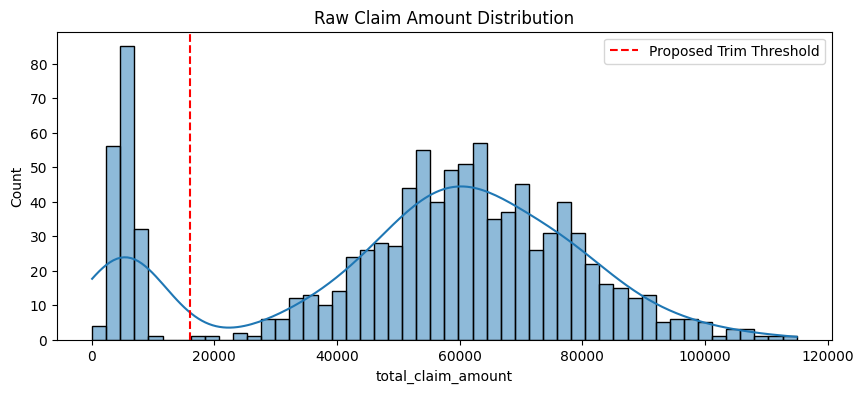

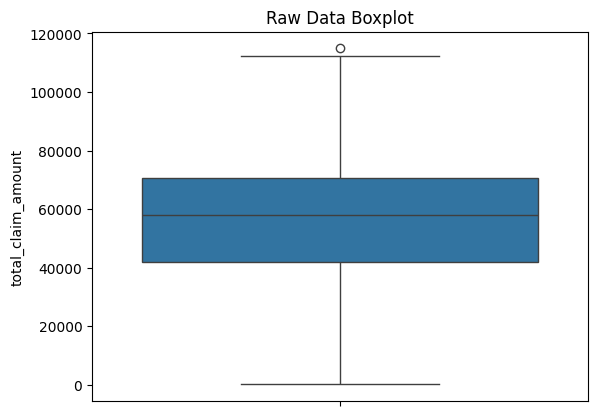

In [ ]:
# RAW DATA EXPLORATION

print("=== Raw Data Stats ===")
print(f"Original Skewness: {df['total_claim_amount'].skew():.2f}")
print(f"Rows: {len(df)}")

# Distribution Plot
plt.figure(figsize=(10, 4))
sns.histplot(df['total_claim_amount'], bins=50, kde=True)
plt.title("Raw Claim Amount Distribution")
plt.axvline(16000, color='red', linestyle='--', label='Proposed Trim Threshold')
plt.legend()
plt.show()

# Boxplot for Outliers
sns.boxplot(y=df['total_claim_amount'])
plt.title("Raw Data Boxplot")
plt.show()

In [ ]:
trim_threshold = 16000
n_affected = (df['total_claim_amount'] < trim_threshold).sum()
percent_affected = (n_affected / len(df)) * 100

print(f"\n=== Trimming Summary ===")
print(f"Claims below ${trim_threshold:,}: {n_affected} rows ({percent_affected:.2f}%)")

# Create a trimmed dataset
df_trimmed = df[df['total_claim_amount'] >= trim_threshold].copy()
print(f"Remaining data after trimming: {len(df_trimmed)} rows")



=== Trimming Summary ===
Claims below $16,000: 178 rows (17.80%)
Remaining data after trimming: 822 rows


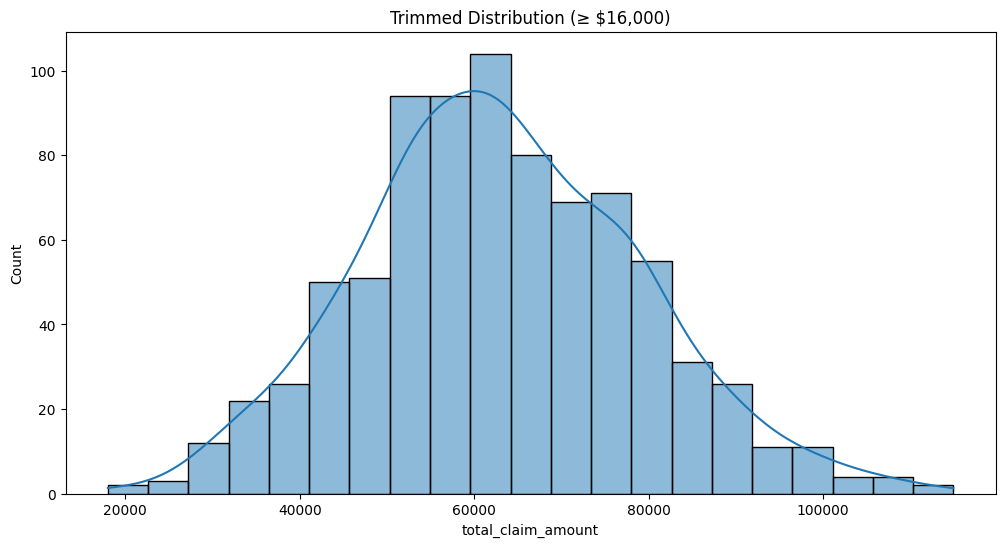

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(df_trimmed['total_claim_amount'], kde=True)
plt.title(f'Trimmed Distribution (≥ ${trim_threshold:,})')
plt.show()


In [ ]:
print(f"New Skewness: {df_trimmed['total_claim_amount'].skew():.2f}")


New Skewness: 0.21



=== Trimmed Data Stats ===
New Skewness: 0.21
Remaining Rows: 822


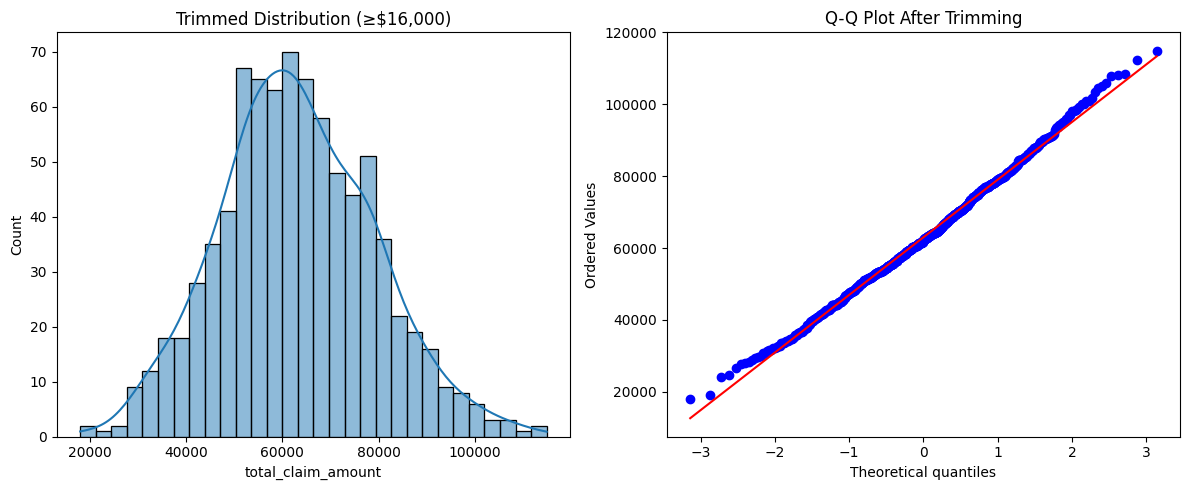


=== Feature-Target Analysis ===


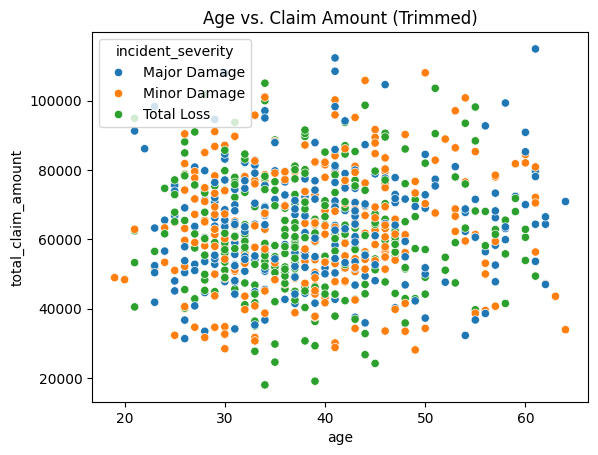

In [ ]:
# TRIMMED DATA VALIDATION
print("\n=== Trimmed Data Stats ===")
print(f"New Skewness: {df_trimmed['total_claim_amount'].skew():.2f}")
print(f"Remaining Rows: {len(df_trimmed)}")

# Distribution Check
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_trimmed['total_claim_amount'], bins=30, kde=True)
plt.title(f"Trimmed Distribution (≥${trim_threshold:,})")

# Q-Q Plot
plt.subplot(1, 2, 2)
stats.probplot(df_trimmed['total_claim_amount'], plot=plt)
plt.title("Q-Q Plot After Trimming")
plt.tight_layout()
plt.show()

# Feature Relationships
print("\n=== Feature-Target Analysis ===")
sns.scatterplot(data=df_trimmed, x='age', y='total_claim_amount', hue='incident_severity')
plt.title("Age vs. Claim Amount (Trimmed)")
plt.show()

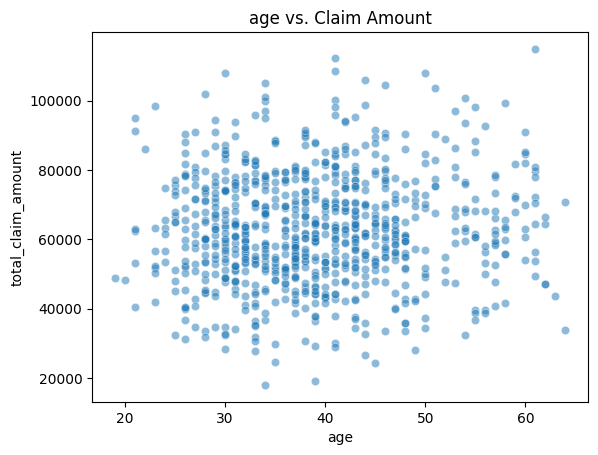

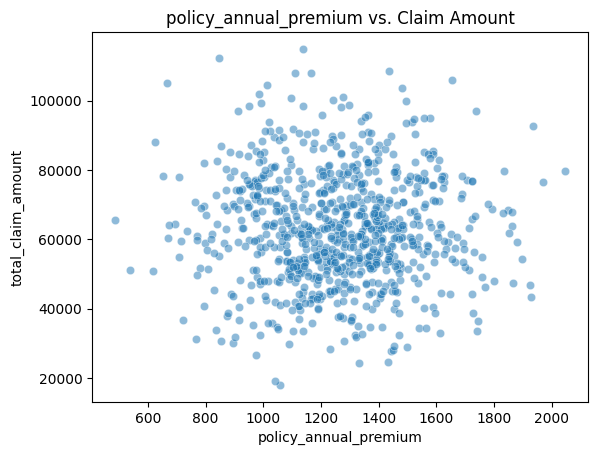

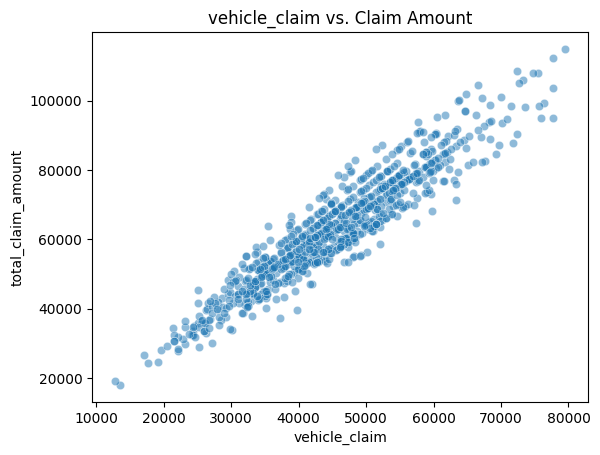

In [ ]:
# Numeric features vs. claim amount
num_features = ['age', 'policy_annual_premium', 'vehicle_claim']
for col in num_features:
    sns.scatterplot(data=df_trimmed, x=col, y='total_claim_amount', alpha=0.5)
    plt.title(f"{col} vs. Claim Amount")
    plt.show()

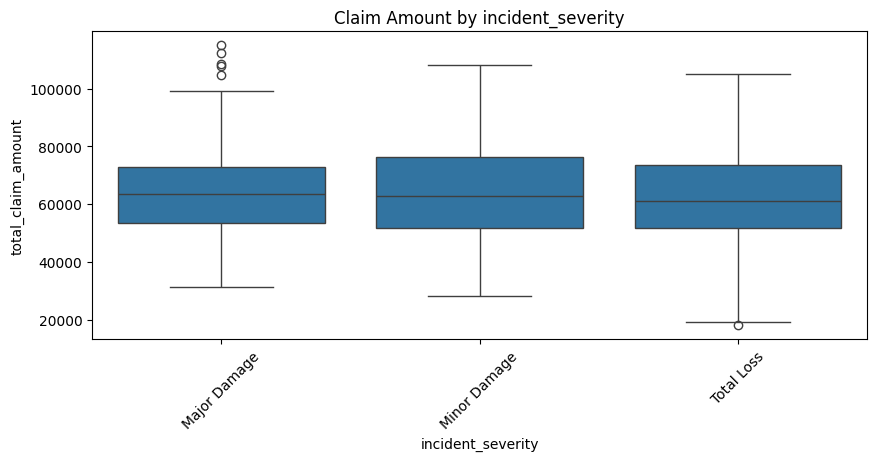

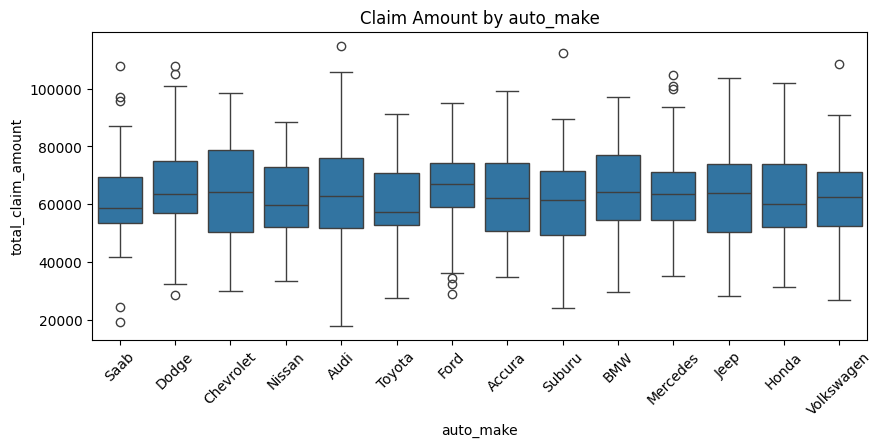

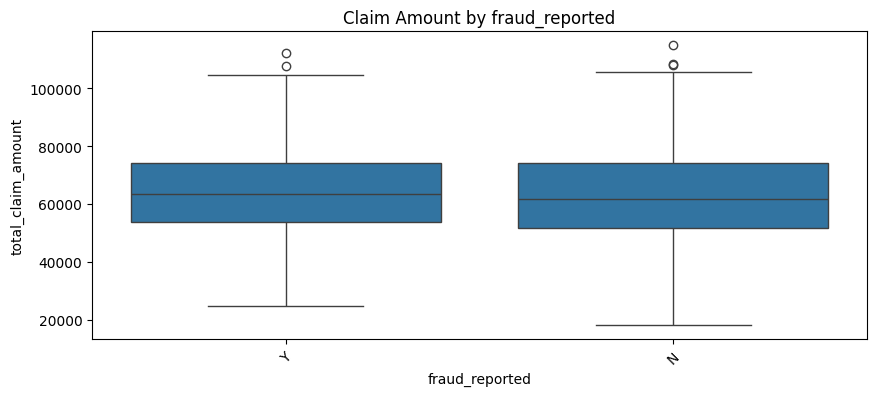

In [ ]:
# Claim amount distribution by categories
cat_features = ['incident_severity', 'auto_make', 'fraud_reported']
for col in cat_features:
    plt.figure(figsize=(10, 4))
    sns.boxplot(data=df_trimmed, x=col, y='total_claim_amount')
    plt.xticks(rotation=45)
    plt.title(f"Claim Amount by {col}")
    plt.show()

In [ ]:
# For ordinal categories (e.g., severity levels)
severity_map = {'Trivial Damage': 0, 'Minor Damage': 1, 'Major Damage': 2, 'Total Loss': 3}
df_trimmed['incident_severity_encoded'] = df_trimmed['incident_severity'].map(severity_map)

# For nominal categories (e.g., auto make)
df_trimmed = pd.get_dummies(df_trimmed, columns=['auto_make'], drop_first=True)

In [ ]:
# Extract year from date or convert to timestamp
df_trimmed['incident_year'] = pd.to_datetime(df_trimmed['incident_date']).dt.year
df_trimmed = df_trimmed.drop(columns=['incident_date'])  # Remove original date column

In [ ]:
numeric_cols = df_trimmed.select_dtypes(include=['int64', 'float64']).columns
corr = df_trimmed[numeric_cols].corr()

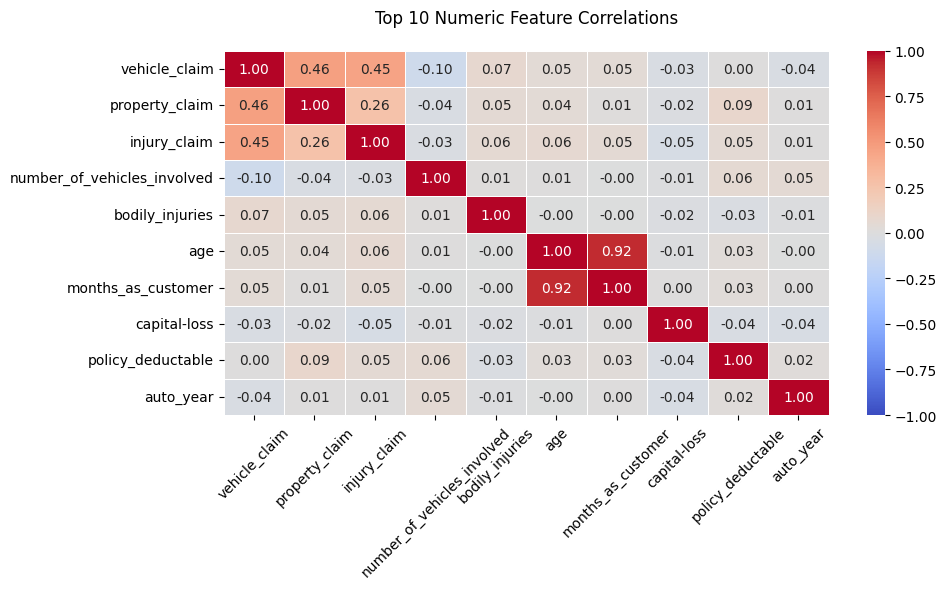

In [ ]:
# Focus on top 10 numeric features correlated with target
top_features = corr['total_claim_amount'].abs().sort_values(ascending=False).index[1:11]

plt.figure(figsize=(10, 6))
sns.heatmap(
    df_trimmed[top_features].corr(),
    annot=True,
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    fmt=".2f",
    linewidths=0.5
)
plt.title("Top 10 Numeric Feature Correlations", pad=20)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Model

In [ ]:
df['insured_education_level'] = df['insured_education_level'].map(education_order)
df['incident_severity'] = df['incident_severity'].map(severity_order)


In [ ]:
from sklearn.preprocessing import StandardScaler

num_features = ['age', 'policy_annual_premium', 'incident_hour_of_the_day', 'claim_frequency']
scaler = StandardScaler()
df[num_features] = scaler.fit_transform(df[num_features])


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Define features and target
X = df.drop(columns=['incident_severity'])
y = df['incident_severity']

# Encode target labels
le = LabelEncoder()
y = le.fit_transform(y)  # Convert categories to numerical labels

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
print(X_train.dtypes)  # Find non-numeric columns


months_as_customer                    float64
age                                   float64
policy_number                           int64
policy_bind_date               datetime64[ns]
policy_state                         category
policy_csl                           category
policy_deductable                     float64
policy_annual_premium                 float64
umbrella_limit                        float64
insured_sex                          category
insured_education_level              category
insured_occupation                   category
insured_hobbies                      category
insured_relationship                 category
capital-gains                         float64
capital-loss                          float64
incident_date                  datetime64[ns]
incident_type                        category
collision_type                       category
authorities_contacted                category
incident_state                       category
incident_hour_of_the_day          

In [ ]:
date_cols = ['policy_bind_date', 'incident_date']

for col in date_cols:
    X_train[col] = pd.to_datetime(X_train[col])
    X_test[col] = pd.to_datetime(X_test[col])

    # Extract meaningful features
    X_train[col + '_year'] = X_train[col].dt.year
    X_train[col + '_month'] = X_train[col].dt.month
    X_train[col + '_dayofweek'] = X_train[col].dt.dayofweek

    X_test[col + '_year'] = X_test[col].dt.year
    X_test[col + '_month'] = X_test[col].dt.month
    X_test[col + '_dayofweek'] = X_test[col].dt.dayofweek

    # Drop original datetime columns
    X_train.drop(columns=[col], inplace=True)
    X_test.drop(columns=[col], inplace=True)


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Select categorical columns
cat_cols = X_train.select_dtypes(include=['category', 'object']).columns

# Apply one-hot encoding (remove sparse=False)
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # sparse is no longer needed
X_train_encoded = encoder.fit_transform(X_train[cat_cols])
X_test_encoded = encoder.transform(X_test[cat_cols])

# Convert back to DataFrame
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(cat_cols))
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(cat_cols))

# Drop original categorical columns and merge encoded features
X_train.drop(columns=cat_cols, inplace=True)
X_test.drop(columns=cat_cols, inplace=True)

X_train = pd.concat([X_train.reset_index(drop=True), X_train_encoded.reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), X_test_encoded.reset_index(drop=True)], axis=1)

 Predicting Claim Severity (Classification)

In [ ]:
# Identify all features except the dropped columns
selected_features = [col for col in X_train.columns if 'edu_occupation_interaction' in col]  # Include one-hot encoded interaction features

# Add other numerical and categorical features (excluding dropped columns)
selected_features += [
    'months_as_customer', 'age', 'policy_deductable', 'policy_annual_premium', 'umbrella_limit',
    'capital-gains', 'capital-loss', 'incident_hour_of_the_day', 'number_of_vehicles_involved',
    'property_damage', 'bodily_injuries', 'witnesses', 'police_report_available', 'auto_year',
    'policy_duration', 'incident_month_sin', 'incident_month_cos', 'incident_dayofweek_sin',
    'incident_dayofweek_cos', 'claim_frequency', 'insured_zip_encoded', 'incident_city_encoded',
    'incident_location_encoded', 'auto_model_encoded'
]

# Ensure only valid features are used
X_train = X_train[selected_features]
X_test = X_test[selected_features]

# Train the RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train_class)

# Predict and evaluate
y_pred_class = clf.predict(X_test)
print(classification_report(y_test_class, y_pred_class))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.42      0.66      0.52        74
           2       0.30      0.13      0.18        61
           3       0.30      0.39      0.34        44

    accuracy                           0.37       200
   macro avg       0.25      0.29      0.26       200
weighted avg       0.31      0.37      0.32       200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train_class)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)
rf_random = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=20, cv=3, scoring='f1_weighted', n_jobs=-1, random_state=42)
rf_random.fit(X_train, y_train_class)

best_rf = rf_random.best_estimator_
y_pred_class = best_rf.predict(X_test)
print(classification_report(y_test_class, y_pred_class))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.42      0.69      0.53        74
           2       0.36      0.15      0.21        61
           3       0.29      0.36      0.32        44

    accuracy                           0.38       200
   macro avg       0.27      0.30      0.26       200
weighted avg       0.33      0.38      0.33       200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


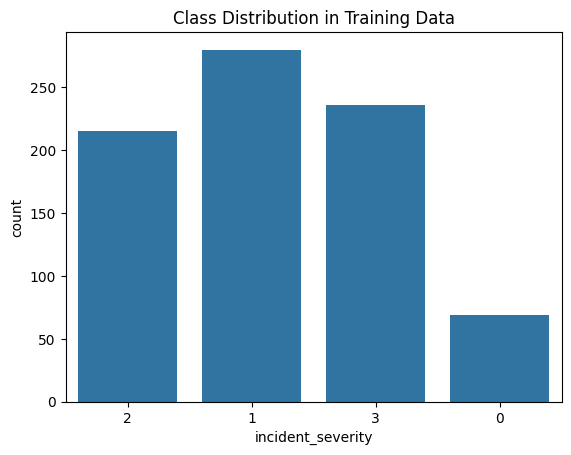

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=y_train_class)
plt.title("Class Distribution in Training Data")
plt.show()


<Axes: title={'center': 'Balanced Class Distribution'}, xlabel='incident_severity'>

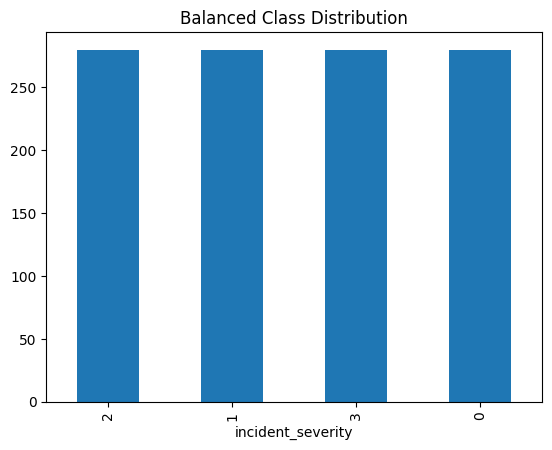

In [ ]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train_class)

# Check new class distribution
pd.Series(y_train_balanced).value_counts().plot(kind='bar', title="Balanced Class Distribution")


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights dynamically
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_class), y=y_train_class)
class_weight_dict = dict(zip(np.unique(y_train_class), class_weights))

# Train Random Forest with class weights
clf = RandomForestClassifier(n_estimators=200, class_weight=class_weight_dict, random_state=42)
clf.fit(X_train, y_train_class)

# Predict and check performance
y_pred_class = clf.predict(X_test)
print(classification_report(y_test_class, y_pred_class))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.37      0.62      0.46        74
           2       0.29      0.11      0.16        61
           3       0.21      0.25      0.23        44

    accuracy                           0.32       200
   macro avg       0.22      0.25      0.21       200
weighted avg       0.27      0.32      0.27       200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Compute class weights dynamically
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_balanced), y=y_train_balanced)
class_weight_dict = dict(zip(np.unique(y_train_balanced), class_weights))

# Train Random Forest with class weights
clf = RandomForestClassifier(n_estimators=300, class_weight=class_weight_dict, random_state=42)
clf.fit(X_train_balanced, y_train_balanced)

# Predict and check performance
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.48      0.89      0.63        18
           1       0.30      0.18      0.23        71
           2       0.32      0.35      0.33        55
           3       0.34      0.39      0.37        56

    accuracy                           0.35       200
   macro avg       0.36      0.45      0.39       200
weighted avg       0.33      0.35      0.33       200



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# Train a Random Forest to get feature importances
clf = RandomForestClassifier(n_estimators=300, random_state=42)
clf.fit(X_train, y_train)

# Select top features
selector = SelectFromModel(clf, max_features=50, prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Check which features were selected
selected_features = X_train.columns[selector.get_support()]
print("Selected Features:", selected_features)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Selected Features: Index(['months_as_customer', 'age', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'capital-gains',
       'capital-loss', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'auto_year', 'policy_duration',
       'incident_month_sin', 'incident_month_cos', 'incident_dayofweek_sin',
       'incident_dayofweek_cos', 'claim_frequency', 'insured_zip_encoded',
       'incident_city_encoded', 'incident_location_encoded',
       'auto_model_encoded'],
      dtype='object')


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=42)
rf.fit(X_train_resampled, y_train_resampled)
y_pred = rf.predict(X_test_selected)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.48      0.89      0.63        18
           1       0.27      0.17      0.21        71
           2       0.28      0.29      0.28        55
           3       0.36      0.41      0.38        56

    accuracy                           0.34       200
   macro avg       0.35      0.44      0.38       200
weighted avg       0.31      0.34      0.32       200



In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importance
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(feature_importances.head(10))  # Top 10 features


incident_location_encoded    0.095373
insured_zip_encoded          0.087241
months_as_customer           0.055911
policy_annual_premium        0.053175
claim_frequency              0.050384
age                          0.049207
policy_duration              0.048795
auto_model_encoded           0.046279
incident_hour_of_the_day     0.046273
auto_year                    0.044072
dtype: float64


In [ ]:
selected_features = [
    'incident_location_encoded', 'insured_zip_encoded', 'months_as_customer',
    'policy_annual_premium', 'claim_frequency', 'age',
    'policy_duration', 'auto_model_encoded', 'incident_hour_of_the_day',
    'auto_year'
]

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Retrain model (try Logistic Regression or Random Forest)
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_selected, y_train)
y_pred = rf.predict(X_test_selected)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.55      0.61      0.58        18
           1       0.44      0.45      0.44        71
           2       0.24      0.22      0.23        55
           3       0.36      0.36      0.36        56

    accuracy                           0.38       200
   macro avg       0.40      0.41      0.40       200
weighted avg       0.37      0.38      0.37       200



In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10]
}

rf_random = RandomizedSearchCV(RandomForestClassifier(), param_grid, cv=5, n_iter=10, random_state=42)
rf_random.fit(X_train_selected, y_train)

print("Best Parameters:", rf_random.best_params_)


Best Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'max_depth': 5}


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_final = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=10,
    max_depth=5,
    random_state=42
)

rf_final.fit(X_train_selected, y_train)
y_pred_final = rf_final.predict(X_test_selected)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_final))


              precision    recall  f1-score   support

           0       0.50      0.56      0.53        18
           1       0.39      0.34      0.36        71
           2       0.29      0.25      0.27        55
           3       0.31      0.39      0.35        56

    accuracy                           0.35       200
   macro avg       0.37      0.39      0.38       200
weighted avg       0.35      0.35      0.35       200



In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=300, max_depth=5, learning_rate=0.1)
xgb.fit(X_train_selected, y_train)
y_pred_xgb = xgb.predict(X_test_selected)

print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.33      0.33      0.33        18
           1       0.36      0.35      0.35        71
           2       0.32      0.29      0.30        55
           3       0.32      0.36      0.34        56

    accuracy                           0.34       200
   macro avg       0.33      0.33      0.33       200
weighted avg       0.34      0.34      0.33       200



In [ ]:
X_train_selected['customer_premium_ratio'] = X_train_selected['policy_annual_premium'] / X_train_selected['months_as_customer']
X_train_selected['age_auto_interaction'] = X_train_selected['age'] * X_train_selected['auto_year']


<ipython-input-143-5b2ecaff38ee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_selected['customer_premium_ratio'] = X_train_selected['policy_annual_premium'] / X_train_selected['months_as_customer']
<ipython-input-143-5b2ecaff38ee>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_selected['age_auto_interaction'] = X_train_selected['age'] * X_train_selected['auto_year']


In [ ]:
xgb = XGBClassifier(n_estimators=500, max_depth=7, learning_rate=0.05)

In [ ]:
xgb = XGBClassifier(n_estimators=500, max_depth=7, learning_rate=0.05)
rf = RandomForestClassifier(n_estimators=500, min_samples_split=5, max_depth=10)

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_selected, y_train)


In [ ]:
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [ ]:
# 🚀 Train Random Forest Model
rf = RandomForestClassifier(n_estimators=300, min_samples_split=10, max_depth=5, random_state=42)
rf.fit(X_train_balanced, y_train_balanced)
y_pred_rf = rf.predict(X_test)

# 🚀 Train XGBoost Model
xgb = XGBClassifier(n_estimators=500, max_depth=7, learning_rate=0.05, random_state=42)
xgb.fit(X_train_balanced, y_train_balanced)
y_pred_xgb = xgb.predict(X_test)


In [ ]:
# 🚀 Train Logistic Regression Model
log_reg = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=1000, random_state=42)
log_reg.fit(X_train_balanced, y_train_balanced)
y_pred_log_reg = log_reg.predict(X_test)

# 🚀 Train SVM Model
svc = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
svc.fit(X_train_balanced, y_train_balanced)
y_pred_svc = svc.predict(X_test)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:

# 📊 Evaluate Performance of Each Model
print("Random Forest Performance:\n", classification_report(y_test, y_pred_rf))
print("XGBoost Performance:\n", classification_report(y_test, y_pred_xgb))
print("Logistic Regression Performance:\n", classification_report(y_test, y_pred_log_reg))
print("SVM Performance:\n", classification_report(y_test, y_pred_svc))

Random Forest Performance:
               precision    recall  f1-score   support

           0       0.47      1.00      0.64        18
           1       0.21      0.04      0.07        71
           2       0.36      0.42      0.39        55
           3       0.42      0.62      0.50        56

    accuracy                           0.40       200
   macro avg       0.37      0.52      0.40       200
weighted avg       0.33      0.40      0.33       200

XGBoost Performance:
               precision    recall  f1-score   support

           0       0.46      0.67      0.55        18
           1       0.43      0.32      0.37        71
           2       0.33      0.36      0.34        55
           3       0.31      0.32      0.31        56

    accuracy                           0.36       200
   macro avg       0.38      0.42      0.39       200
weighted avg       0.37      0.36      0.36       200

Logistic Regression Performance:
               precision    recall  f1-score   

In [ ]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=1000)
log_reg.fit(X_train_selected, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, multi_class='ovr')

In [ ]:
from sklearn.svm import SVC
svc = SVC(kernel='rbf', C=1, gamma='scale')
svc.fit(X_train_selected, y_train)


SVC(C=1)

In [ ]:
from sklearn.ensemble import VotingClassifier
ensemble = VotingClassifier(estimators=[
    ('rf', rf),
    ('xgb', xgb),
    ('log_reg', log_reg)
], voting='soft')


 Predicting Claim Amount (Regression)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize the model
lin_reg = LinearRegression()

# Fit the model
lin_reg.fit(X_train, y_train)

# Predictions
y_pred_lin = lin_reg.predict(X_test)

# Model Evaluation
mae = mean_absolute_error(y_test, y_pred_lin)
mse = mean_squared_error(y_test, y_pred_lin)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred_lin)

print(f"Linear Regression Performance:\nMAE: {mae}\nMSE: {mse}\nRMSE: {rmse}\nR² Score: {r2}")


Linear Regression Performance:
MAE: 0.7351398223350363
MSE: 0.7749123584182087
RMSE: 0.880291064602049
R² Score: 0.16673850542411517


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize models
rf_reg = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42)
xgb_reg = XGBRegressor(n_estimators=300, max_depth=10, learning_rate=0.1, random_state=42)

# Train models
rf_reg.fit(X_train, y_train)
xgb_reg.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_reg.predict(X_test)
y_pred_xgb = xgb_reg.predict(X_test)

# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"{model_name} Performance:")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"R² Score: {r2}")
    print("="*50)

# Evaluate models
evaluate_model(y_test, y_pred_rf, "Random Forest Regressor")
evaluate_model(y_test, y_pred_xgb, "XGBoost Regressor")


Random Forest Regressor Performance:
MAE: 0.6641604820575481
MSE: 0.6015145296902716
RMSE: 0.7755736777961664
R² Score: 0.35319279583830576
XGBoost Regressor Performance:
MAE: 0.6809173822402954
MSE: 0.6593883037567139
RMSE: 0.8120272801801143
R² Score: 0.2909613251686096


In [ ]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)


(800, 122) (200, 122)
(800,) (200,)


ASSUMPTIONS